# 개별 코드

In [1]:
# 랜덤 시드 설정
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# 데이터 불러오기
from tensorflow.keras import datasets
(X_tn0,y_tn0),(X_te0,y_te0)=datasets.mnist.load_data()

In [3]:
# 원본 데이터 차원 확인
print(X_tn0.shape)
print(y_tn0.shape)
print(X_te0.shape)
print(y_te0.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


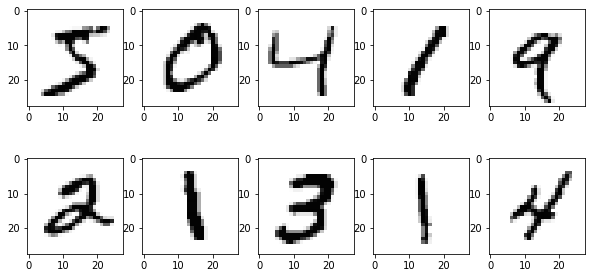

In [4]:
# 원본 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn0[i].reshape((28, 28)), 
               cmap='Greys')
plt.show()

In [5]:
# 피쳐 데이터 스케일 조정
X_tn_re = X_tn0.reshape(60000,28,28,1)
X_tn = X_tn_re/255
print(X_tn.shape)

X_te_re = X_te0.reshape(10000,28,28,1)
X_te = X_te_re/255
print(X_te.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# 노이즈 피쳐 데이터 
import numpy as np
X_tn_noise = X_tn + np.random.uniform(-1,1,size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1,1,size=X_te.shape)

In [7]:
# 노이즈 데이터 스케일링
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

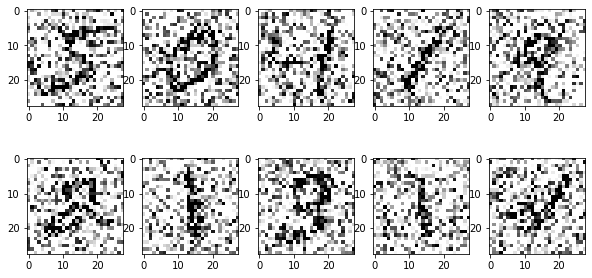

In [8]:
# 노이즈 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn_ns[i].reshape((28, 28)), 
               cmap='Greys')
plt.show()

In [9]:
# 오토인코더
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation

# 인코더
input_layer1 = Input(shape=(28,28,1))
x1 = Conv2D(20, kernel_size=(5,5), 
            padding='same')(input_layer1)
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPool2D(pool_size=2, 
                          padding='same')(x1)
encoder = Model(input_layer1, output_layer1)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 인코더 아웃풋 차원확인
print(output_layer1.shape)
print(output_layer1.shape[0])
print(output_layer1.shape[1])
print(output_layer1.shape[2])
print(output_layer1.shape[3])

(None, 14, 14, 20)
None
14
14
20


In [18]:
print(output_layer1.shape[1:4])

(14, 14, 20)


In [19]:
# 디코더
input_layer2 = Input(shape=output_layer1.shape[1:4])
x2 = Conv2D(10, kernel_size=(5,5), 
            padding='same')(input_layer2)
x2 = Activation(activation='relu')(x2)
x2 = UpSampling2D()(x2)
x2 = Conv2D(1, kernel_size=(5,5), 
            padding='same')(x2)
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14, 14, 20)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        5010      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 10)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         251       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 1)         0         
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________

In [12]:
# 오토인코더
input_auto = Input(shape=(28, 28, 1))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto) 
auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                (None, 14, 14, 20)        520       
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         5261      
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 모형 컴파일
auto_encoder.compile(loss='mean_squared_error', 
                     optimizer='adam', 
                     metrics=['mean_squared_error'])

In [14]:
# 학습
hist = auto_encoder.fit(X_tn_ns, X_tn, 
                        epochs=1, 
                        batch_size=100)

Train on 60000 samples
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.0275 - mean_squared_error: 0.0275


In [16]:
# 예측값
X_pred = auto_encoder.predict(X_tn_ns)

In [17]:
# 예측값 차원
print(X_pred.shape)

(60000, 28, 28, 1)


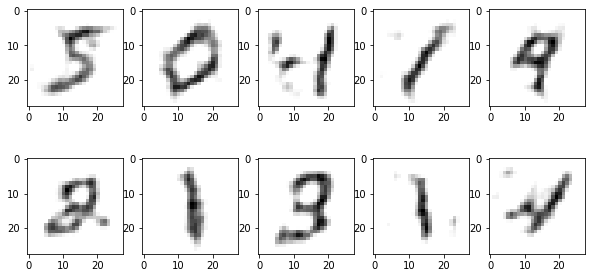

In [18]:
# 오토인코딩 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_pred[i].reshape((28, 28)), 
               cmap='Greys')
plt.show()

# 통합 코드

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation




# 랜덤 시드 설정
np.random.seed(0)
tf.random.set_seed(0)

# 데이터 불러오기
(X_tn0,y_tn0),(X_te0,y_te0)=datasets.mnist.load_data()

# 원본 데이터 차원 확인
print(X_tn0.shape)
print(y_tn0.shape)
print(X_te0.shape)
print(y_te0.shape)

# 원본 데이터 시각화
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn0[i].reshape((28, 28)), 
               cmap='Greys')
plt.show()

# 피쳐 데이터 스케일 조정
X_tn_re = X_tn0.reshape(60000,28,28,1)
X_tn = X_tn_re/255
print(X_tn.shape)

X_te_re = X_te0.reshape(10000,28,28,1)
X_te = X_te_re/255
print(X_te.shape)

# 노이즈 피쳐 데이터 
import numpy as np
X_tn_noise = X_tn + np.random.uniform(-1,1,size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1,1,size=X_te.shape)

# 노이즈 데이터 스케일링
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

# 노이즈 데이터 시각화
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn_ns[i].reshape((28, 28)), 
               cmap='Greys')
plt.show()

# 오토인코더
# 인코더
input_layer1 = Input(shape=(28,28,1))
x1 = Conv2D(20, kernel_size=(5,5), 
            padding='same')(input_layer1)
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPool2D(pool_size=2, 
                          padding='same')(x1)
encoder = Model(input_layer1, output_layer1)
encoder.summary()


# 인코더 아웃풋 차원확인
print(output_layer1.shape)
print(output_layer1.shape[0])
print(output_layer1.shape[1])
print(output_layer1.shape[2])
print(output_layer1.shape[3])

# 디코더
input_layer2 = Input(shape=(shape=output_layer1.shape[1:4]))
x2 = Conv2D(10, kernel_size=(5,5), 
            padding='same')(input_layer2)
x2 = Activation(activation='relu')(x2)
x2 = UpSampling2D()(x2)
x2 = Conv2D(1, kernel_size=(5,5), 
            padding='same')(x2)
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()

# 오토인코더
input_auto = Input(shape=(28, 28, 1))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto) 
auto_encoder.summary()

# 모형 컴파일
auto_encoder.compile(loss='mean_squared_error', 
                     optimizer='adam', 
                     metrics=['mean_squared_error'])

# 학습
hist = auto_encoder.fit(X_tn_ns, X_tn, 
                        epochs=1, 
                        batch_size=100)

# 예측값
X_pred = auto_encoder.predict(X_tn_ns)

# 예측값 차원
print(X_pred.shape)

# 오토인코더 데이터 시각화
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_pred[i].reshape((28, 28)), 
               cmap='Greys')
plt.show()